**Table of Contents:**

1. Importing your libraries and data
2. Subsetting, wrangling, and cleaning time-series data
3. Time series analysis: decomposition
4. Testing for stationarity
5. Stationarizing the Indian Crop Production data

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles 
# statistical models.
import os
import warnings # This is a library that handles warnings.

warnings.filterwarnings("ignore") # Disable deprecation warnings that could indicate, for instance, a suspended library or 
# feature. These are more relevant to developers and very seldom to analysts.

plt.style.use('fivethirtyeight') # This is a styling option for how your plots will appear.

In [ ]:
df = pd.read_excel('/content/Year-season-production.xlsx')

In [ ]:
df.head(2)

,Crop_Year,Season,Harvesting Month,Harvesting month-year,Sum of Production
0,1997,Autumn,November,1997-09-01,240551.0
1,1997,Kharif,October,1997-08-01,3541703.0


3. Make a subset of your data set if necessary. Think about the historical domain of the series to decide if you need to (if there are irrelevant historical events in your data that would bias your analysis, for example). Also, make sure your set doesn’t include any forecasted data.

*   In a markdown cell below the subset (if you make one), explain what logic you were following when selecting your data points.
*   Remember that if you subset your data, you’ll need to reset the index, subset, then reset the “Date” column as your index in the new dataframe.



In [ ]:
df_sub = df[['Harvesting month-year','Sum of Production']]

I have chosen the particular columns because a time series needs to have one datetime variable, and I want to analysis how crop production has developed over the course of the years. 

In [ ]:
df_sub.shape

(142, 2)

In [ ]:
df_sub = df_sub.dropna()

In [ ]:
df_sub.shape

(118, 2)

In [ ]:
df_sub.head()

,Harvesting month-year,Sum of Production
0,1997-09-01,240551.0
1,1997-08-01,3541703.0
2,1997-04-01,2966057.0
3,1997-06-01,662546.0
5,1997-02-01,80432.0


In [ ]:
# Set the "Year" column as the index
from datetime import datetime

df_sub['datetime'] = pd.to_datetime(df_sub['Harvesting month-year']) # Create a datetime column from "Date.""

df_sub = df_sub.set_index('datetime') # Set the datetime as the index of the dataframe.
df_sub.drop(['Harvesting month-year'], axis=1, inplace=True) # Drop the "Date" column.
df_sub.head()

,Sum of Production
datetime,
1997-09-01,240551.0
1997-08-01,3541703.0
1997-04-01,2966057.0
1997-06-01,662546.0
1997-02-01,80432.0


4. Create a line chart of your data.

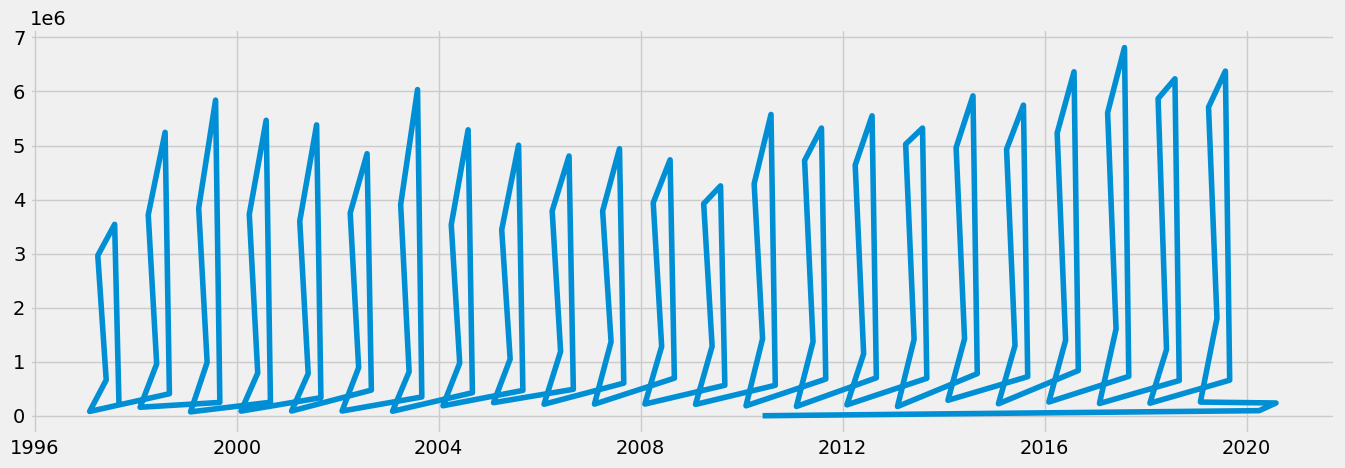

In [ ]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100) # The dpi argument controls the quality of the visualization here. When it's set to 100,
# it will produce lower-than-standard quality, which is useful if, similar to this notebook, you'll have a lot of plots.
# A large number of plots will increase the size of the notebook, which could take more time to load and eat up a lot of RAM!

plt.plot(df_sub)

In [ ]:
# Check for missing values (shouldn't have any)

df_sub.isnull().sum() 

Sum of Production    0
dtype: int64

In [ ]:
# Check for duplicates

dups = df.duplicated()
dups.sum()

# No dups!

0

5. Decompose the data’s components.

*   Analyze the results from the plot in a markdown cell.



In [ ]:
df_sub.sort_index(inplace=True)

In [ ]:
df_sub

,Sum of Production
datetime,
1997-02-01,80432.00
1997-04-01,2966057.00
1997-06-01,662546.00
1997-08-01,3541703.00
1997-09-01,240551.00
...,...
2019-06-01,1799941.80
2019-08-01,6377565.16
2019-09-01,659214.40


In [ ]:
pd.infer_freq(df.index.values)

'N'

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [ ]:
from statsmodels.tsa.tsatools import freq_to_period
# Decompose the time series using an additive model


decomposition = seasonal_decompose(df_sub, model='additive', period= 5)

In [ ]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

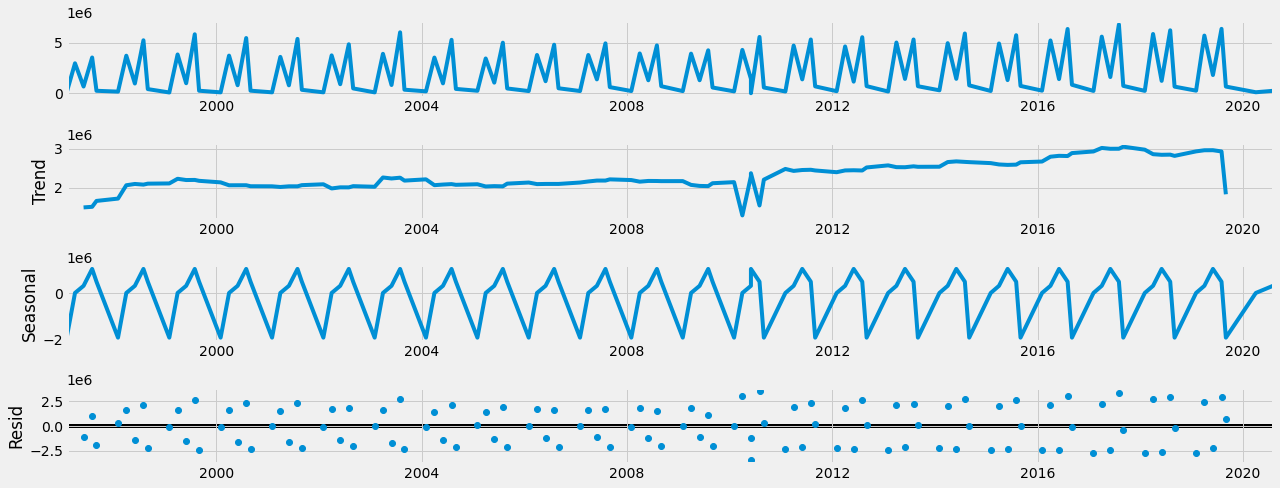

In [ ]:
# Plot the separate components

decomposition.plot()
plt.show()

6. Conduct a Dickey-Fuller test to check for stationarity.

*   Interpret the results in a markdown cell and reference your null hypothesis.



In [ ]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers. This is why you need to also define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(df_sub['Sum of Production'])

Dickey-Fuller Stationarity test:
Test Statistic                  -2.195397
p-value                          0.207920
Number of Lags Used              6.000000
Number of Observations Used    111.000000
Critical Value (1%)             -3.490683
Critical Value (5%)             -2.887952
Critical Value (10%)            -2.580857
dtype: float64


p-value > 0.05, test statistic > critical value (both 10% and 5%). So we need to stationarize this data. 

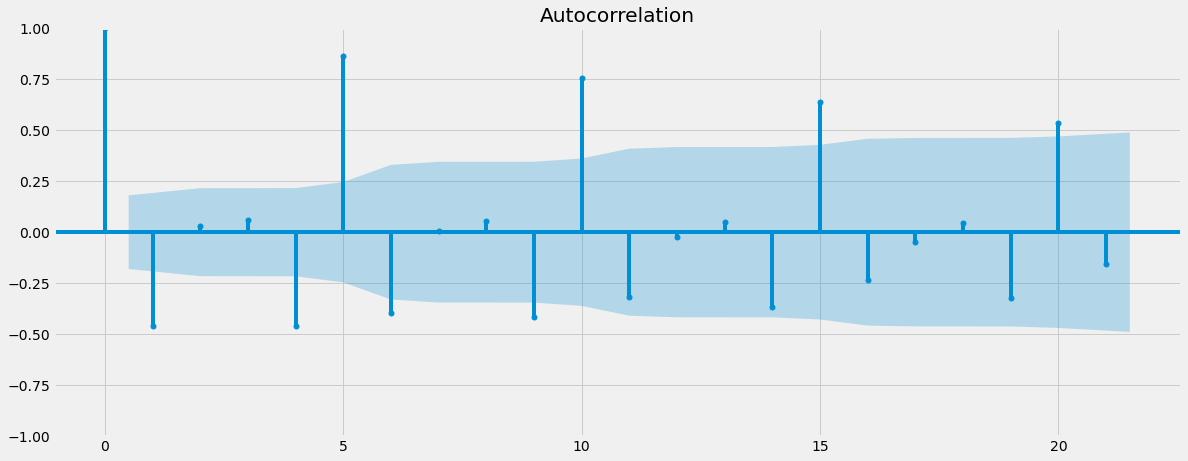

In [ ]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(df_sub)
plt.show()

7. If your data isn’t stationary, conduct a round of differencing on it and repeat step 6.

In [ ]:
data_diff = df_sub - df_sub.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [ ]:
data_diff.dropna(inplace = True) # Here, you remove the missing values that came about as a result of the differencing. 
# You need to remove these or you won't be able to run the Dickey-Fuller test.

In [ ]:
data_diff.head(10)

,Sum of Production
datetime,
1997-04-01,2885625.0
1997-06-01,-2303511.0
1997-08-01,2879157.0
1997-09-01,-3301152.0
1998-02-01,-82711.0
1998-04-01,3560171.0
1998-06-01,-2758099.0
1998-08-01,4285206.0
1998-09-01,-4837495.0


In [ ]:
data_diff.columns

Index(['Sum of Production'], dtype='object')

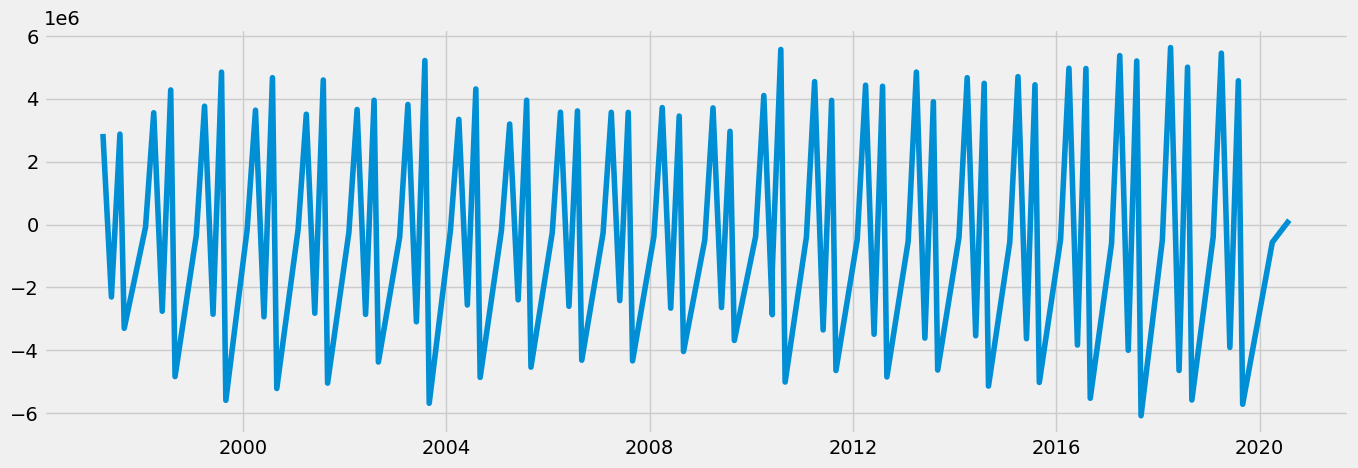

In [ ]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [ ]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                -1.124523e+01
p-value                        1.766394e-20
Number of Lags Used            5.000000e+00
Number of Observations Used    1.110000e+02
Critical Value (1%)           -3.490683e+00
Critical Value (5%)           -2.887952e+00
Critical Value (10%)          -2.580857e+00
dtype: float64


The data is now stationary

8. If your data still isn’t stationary, perform another round of differencing and repeat step 6.

In [ ]:
#No need for another round of differencing

9. Check your data’s autocorrelations.

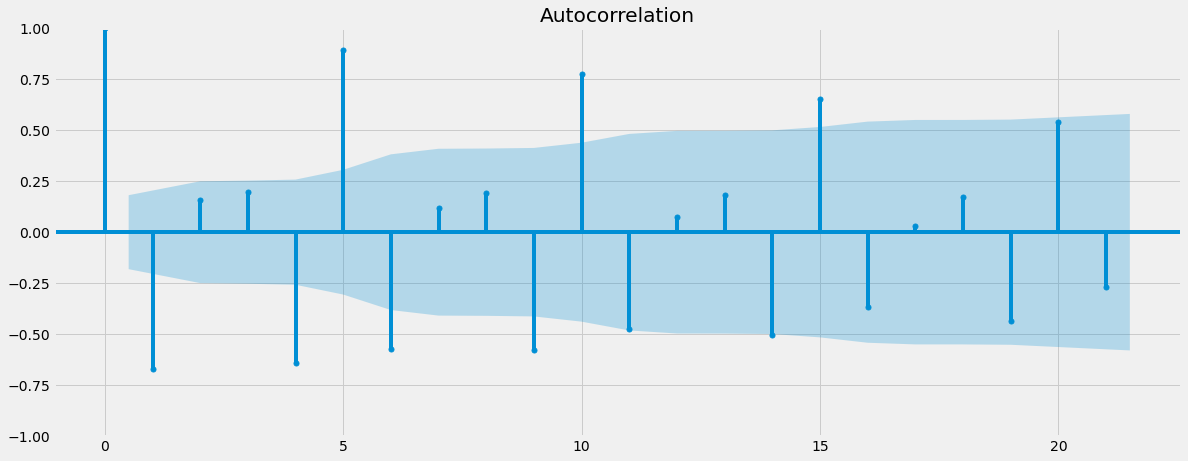

In [ ]:
plot_acf(data_diff)
plt.show()

**Bonus Task: Forecasting with ARIMA**

**Directions**

1. Continue with the same notebook from your Exercise task by adding a markdown
section called “Bonus Task” at the bottom.

2. Start by plotting partial autocorrelations and autocorrelations for your data.


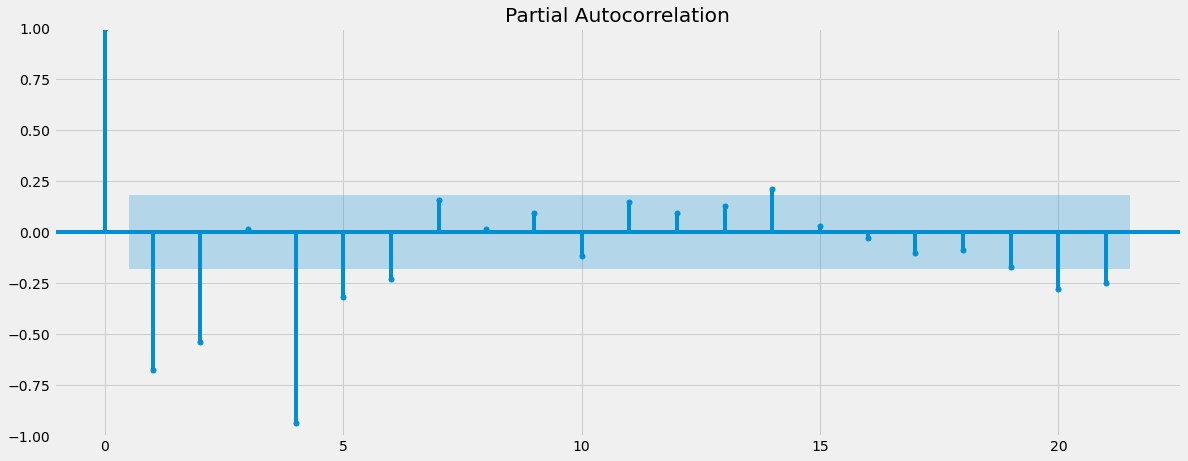

In [ ]:
#plotting partial autocorrelations for the differenced data

plot_pacf(data_diff)
plt.show()

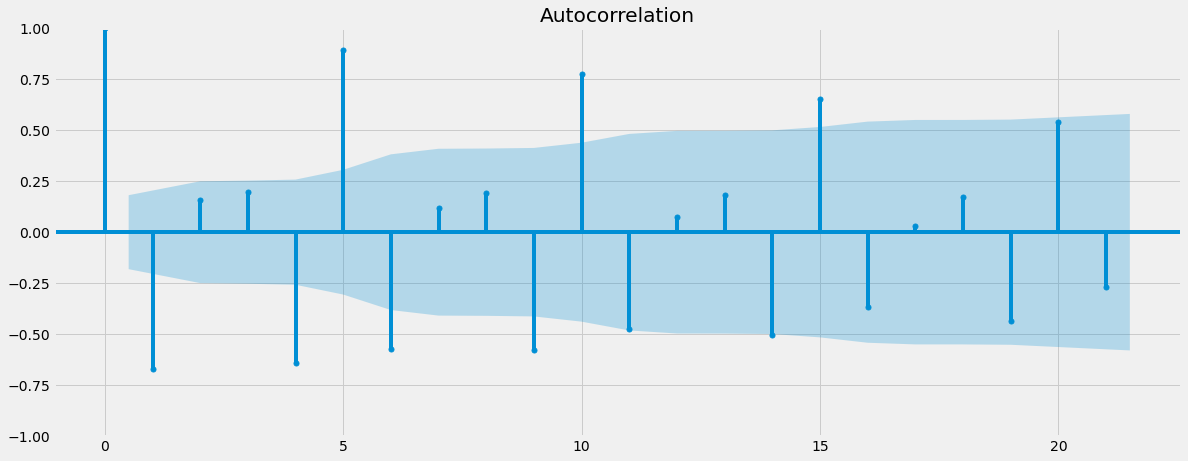

In [ ]:
#plotting autocorrelations for the differenced data

plot_acf(data_diff)
plt.show()

3. Analyze what you see: how many AR and MA terms do you think you’ll need for your first iteration?

*   Add a markdown section under the plots explaining your choice.




**Answer:** In the Partial Autocorrelation (PACF) plot, there are three highly negative bars at lags 1, 2 and 4 (points along the x-axis). There is also a highly positive bar at lag 0, and it's the 1st bar. p = 1 would be a good choice in this case, since the first bar is the highest positive one.


On the other hand, there are 4 significant positive and 4 significant negative bars in the Autocorrelation (ACF) plot. q = 4 would be a good choice for the 4 high positive bars

Here, d=1 since the data has been differenced only once

Reference: https://analyticsindiamag.com/quick-way-to-find-p-d-and-q-values-for-arima/#:~:text=Draw%20a%20partial%20autocorrelation%20graph,to%20the%20ACF%20is%20q.

4. Split your data into a training set and a test set. Aim for a 70/30 or 80/20 split (unless there’s a contextual point that seems logical for a split).


*   For example, in this Bonus Exercise, we wanted to see whether we could
forecast the effects of the crisis, so we split the data after 2010. Since the test set still contained around 25 percent of the data, however, it still adhered to the rules for train/test split.




In [ ]:
import itertools
from statsmodels.tsa.arima.model import ARIMA

In [ ]:
#the p has been changed from 1 to 4 because we were getting many p-values higher than 0.05 in the model summary

p = 4
d = 1
q = 4

In [ ]:
# 75-25 split

train = data_diff['Sum of Production'][:88]
test = data_diff['Sum of Production'][87:]

In [ ]:
data_diff.shape

(117, 1)

In [ ]:
train.shape

(88,)

In [ ]:
test.shape

(30,)

In [ ]:
test

datetime
2014-06-01   -3.539355e+06
2014-08-01    4.496104e+06
2014-09-01   -5.139755e+06
2015-02-01   -5.578213e+05
2015-04-01    4.709239e+06
2015-06-01   -3.632348e+06
2015-08-01    4.449259e+06
2015-09-01   -5.023940e+06
2016-02-01   -4.697572e+05
2016-04-01    4.975946e+06
2016-06-01   -3.834024e+06
2016-08-01    4.968481e+06
2016-09-01   -5.527617e+06
2017-02-01   -6.098848e+05
2017-04-01    5.379224e+06
2017-06-01   -4.001084e+06
2017-08-01    5.207458e+06
2017-09-01   -6.083510e+06
2018-02-01   -4.963920e+05
2018-04-01    5.634858e+06
2018-06-01   -4.642543e+06
2018-08-01    5.009476e+06
2018-09-01   -5.582904e+06
2019-02-01   -3.981900e+05
2019-04-01    5.456214e+06
2019-06-01   -3.909965e+06
2019-08-01    4.577623e+06
2019-09-01   -5.718351e+06
2020-04-01   -5.642404e+05
2020-08-01    1.417420e+05
Name: Sum of Production, dtype: float64

5. Perform your first iteration of the ARIMA model

In [ ]:
model = ARIMA(train, order=(p, d, q))
fitted = model.fit()
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:      Sum of Production   No. Observations:                   88
Model:                 ARIMA(4, 1, 4)   Log Likelihood               -1305.540
Date:                Sat, 25 Mar 2023   AIC                           2629.079
Time:                        22:06:38   BIC                           2651.272
Sample:                             0   HQIC                          2638.016
                                 - 88                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9685      0.099     -9.828      0.000      -1.162      -0.775
ar.L2         -0.9536      0.112     -8.546      0.000      -1.172      -0.735
ar.L3         -0.9097      0.095     -9.600      0.0

**Note:** Since the data is seasonal, SARIMAX model has been automatically selected instead of ARIMA.

All the AR terms and 3 out of 4 MA terms are significant

I had to chose p=1 and q=2 for the SARIMA model after getting significant p-values for these components compared to the previous values for p and q.

In [ ]:
model = sm.tsa.statespace.SARIMAX(df_sub, order=(1, 1, 2), seasonal_order=(1, 1, 2, 5))
fitted_sarimax = model.fit()
print(fitted_sarimax.summary())

                                     SARIMAX Results                                     
Dep. Variable:                 Sum of Production   No. Observations:                  118
Model:             SARIMAX(1, 1, 2)x(1, 1, 2, 5)   Log Likelihood               -1709.751
Date:                           Sat, 25 Mar 2023   AIC                           3433.502
Time:                                   22:20:10   BIC                           3452.532
Sample:                                        0   HQIC                          3441.223
                                           - 118                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7555      0.312     -2.422      0.015      -1.367      -0.144
ma.L1         -0.0411      0.300     -0.137

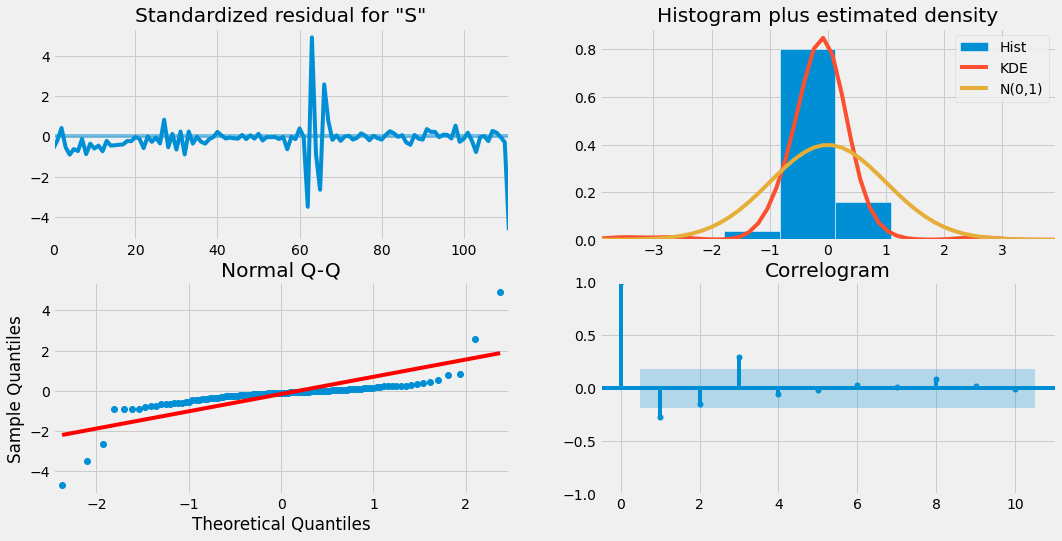

In [ ]:
fitted_sarimax.plot_diagnostics(figsize=(16, 8))
plt.show()

<Axes: xlabel='datetime'>

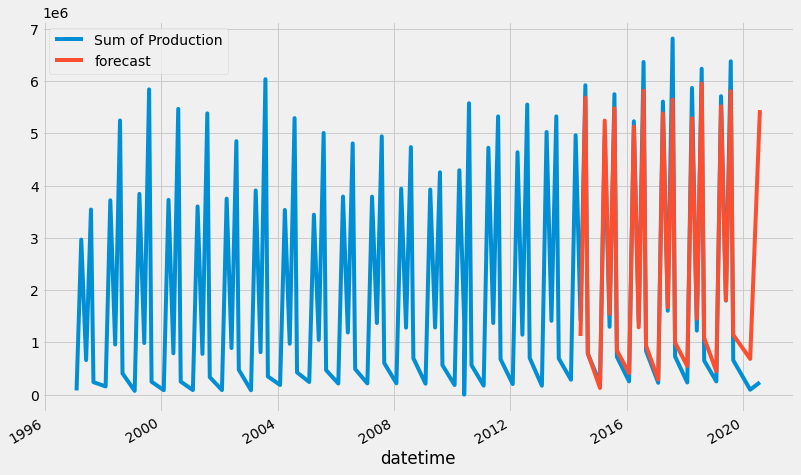

In [ ]:
df_sub['forecast'] = fitted_sarimax.predict(start = 88, end = 117, dynamic = True)

df_sub[['Sum of Production','forecast']].plot(figsize=(12,8))

6. Check the summary statistics and line plot of the forecasted vs. actual values.

*   In a markdown section, interpret the results.


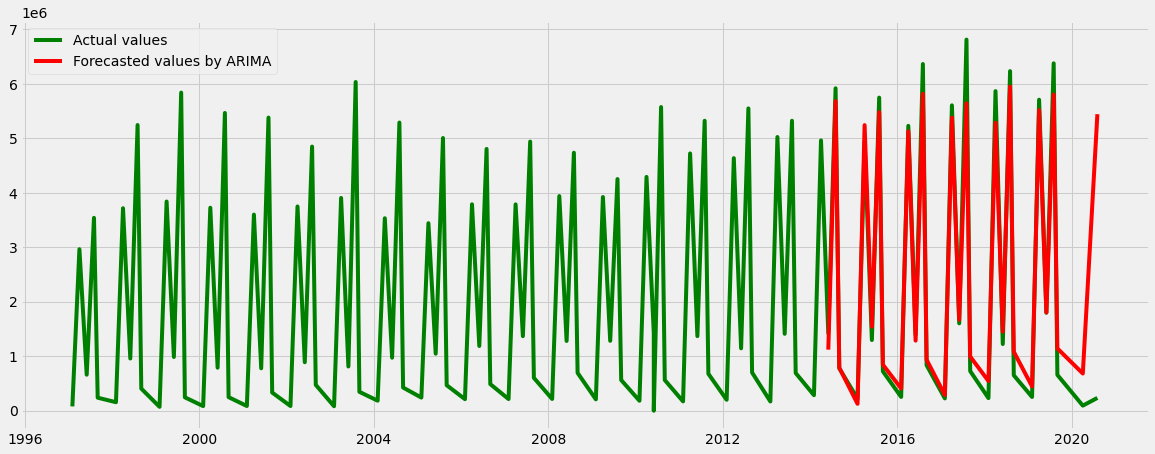

In [ ]:
plt.plot(df_sub['Sum of Production'], color='Green', label = 'Actual values')
plt.plot(df_sub['forecast'], color='Red', label = 'Forecasted values by ARIMA')
plt.legend()

**Interpretation:** The forecasted values are quite close to the actual values, except for the year 2020. 

it's because the covid pandemic was unforeseen, our model didn't know such a pandemic would occur in 2020 and as a result the production would be very low compared to the previous years. 

7. If the fit isn’t satisfactory, adjust your model parameters and perform another iteration.

*   Explain your choices and interpretation of the new results in a markdown
section


In [133]:
#The fit was satisfactory

8. Run as many iterations as it takes to get a model that fits well.


**Part 2:** **Forecasting with Prophet**

In [ ]:
!pip install fbprophet

In [124]:
!apt-get -qq install -y fbprophet

E: Unable to locate package fbprophet


In [126]:
!conda install -c conda-forge fbprophet -y

/bin/bash: conda: command not found


In [ ]:
!pip install prophet

In [86]:
import prophet
from prophet import Prophet

In [87]:
dir(Prophet)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_load_stan_backend',
 '_logistic_uncertainty',
 '_make_historical_mat_time',
 '_make_trend_shift_matrix',
 '_sample_uncertainty',
 'add_country_holidays',
 'add_group_component',
 'add_regressor',
 'add_seasonality',
 'construct_holiday_dataframe',
 'fit',
 'flat_growth_init',
 'flat_trend',
 'fourier_series',
 'initialize_scales',
 'linear_growth_init',
 'logistic_growth_init',
 'make_all_seasonality_features',
 'make_future_dataframe',
 'make_holiday_features',
 'make_seasonality_features',
 'parse_seasonality_args',
 'percentile',
 'piecewise_linear',
 'piecewise_logistic',
 'plot',
 'plot_components',
 'predict',
 'p

In [88]:

#initializing the model 

model = Prophet()

In [96]:
#prophet requires datetime to be in separate column, not in the index column 

df_sub_2 = df[['Harvesting month-year','Sum of Production']]

In [97]:
df_sub_2.shape

(142, 2)

In [98]:
df_sub_2 = df_sub_2.dropna()

In [99]:
df_sub_2.shape

(118, 2)

In [106]:
df_sub_2.head()

,Harvesting month-year,Sum of Production
0,1997-09-01,240551.0
1,1997-08-01,3541703.0
2,1997-04-01,2966057.0
3,1997-06-01,662546.0
5,1997-02-01,80432.0


In [104]:
#converting month-year to datetime

df_sub_2['Harvesting month-year'] = pd.to_datetime(df_sub_2['Harvesting month-year'])

In [108]:
df_sub_2.rename(columns = {'Harvesting month-year':'ds'}, inplace = True)
df_sub_2.rename(columns = {'Sum of Production':'y'}, inplace = True)

In [110]:
df_sub_2.head()

,ds,y
0,1997-09-01,240551.0
1,1997-08-01,3541703.0
2,1997-04-01,2966057.0
3,1997-06-01,662546.0
5,1997-02-01,80432.0


In [111]:
model.fit(df_sub_2)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpj3iva_s6/5ih7xa7b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpj3iva_s6/8o5g98vk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88554', 'data', 'file=/tmp/tmpj3iva_s6/5ih7xa7b.json', 'init=/tmp/tmpj3iva_s6/8o5g98vk.json', 'output', 'file=/tmp/tmpj3iva_s6/prophet_modelqw3w33fi/prophet_model-20230326044157.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:41:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:41:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [112]:
model.component_modes

{'additive': ['yearly',
  'additive_terms',
  'extra_regressors_additive',
  'holidays'],
 'multiplicative': ['multiplicative_terms', 'extra_regressors_multiplicative']}

In [113]:
#creating future forecast

future_dates = model.make_future_dataframe(periods = 365)

In [114]:
prediction = model.predict(future_dates)

In [115]:
prediction.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1997-02-01,907961.596087,-1.063676e+06,8.562068e+05,907961.596087,907961.596087,-9.942494e+05,-9.942494e+05,-9.942494e+05,-9.942494e+05,-9.942494e+05,-9.942494e+05,0.0,0.0,0.0,-8.628785e+04
1,1997-04-01,911991.406563,2.841158e+06,4.933798e+06,911991.406563,911991.406563,2.928213e+06,2.928213e+06,2.928213e+06,2.928213e+06,2.928213e+06,2.928213e+06,0.0,0.0,0.0,3.840205e+06
2,1997-06-01,916157.820783,-1.141465e+05,1.964032e+06,916157.820783,916157.820783,-5.202800e+04,-5.202800e+04,-5.202800e+04,-5.202800e+04,-5.202800e+04,-5.202800e+04,0.0,0.0,0.0,8.641298e+05
3,1997-08-01,920324.235003,3.888289e+06,5.886294e+06,920324.235003,920324.235003,3.981818e+06,3.981818e+06,3.981818e+06,3.981818e+06,3.981818e+06,3.981818e+06,0.0,0.0,0.0,4.902142e+06
4,1997-09-01,922441.593050,-7.915977e+05,1.266351e+06,922441.593050,922441.593050,-6.353007e+05,-6.353007e+05,-6.353007e+05,-6.353007e+05,-6.353007e+05,-6.353007e+05,0.0,0.0,0.0,2.871409e+05


In [116]:
#checking the latest future date created by prophet
future_dates.tail()

,ds
477,2021-07-28
478,2021-07-29
479,2021-07-30
480,2021-07-31
481,2021-08-01


The dataset contains records till 2020. So this creation has been appropriate.

The output feature is denoted as yhat in prediction.

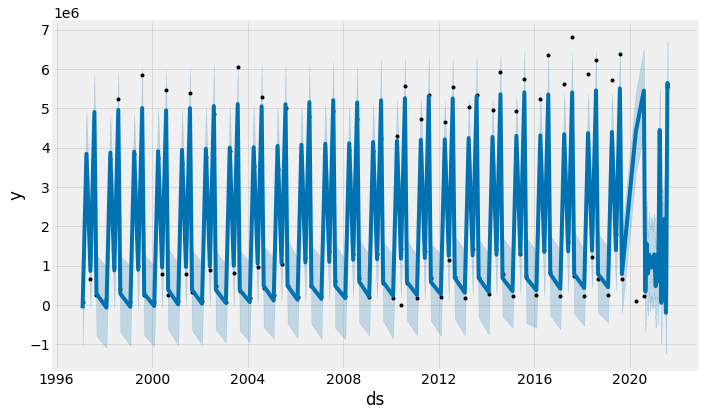

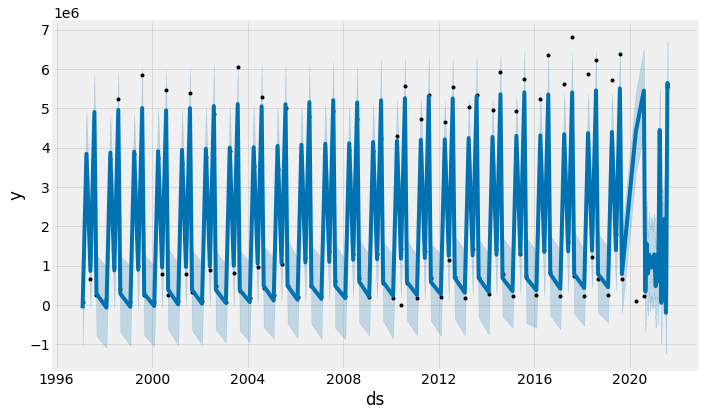

In [117]:
model.plot(prediction)



*   The dotted points are the real data
*   The deep blue line is the projection
*   The light blue space is the trend space
*   The part of the deep blue line beyond 2020 is the forecast for 2021







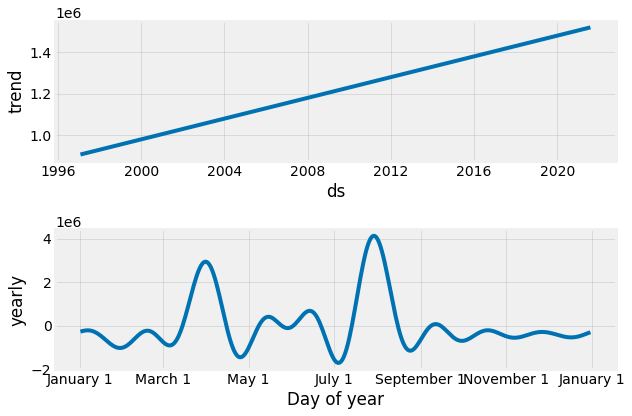

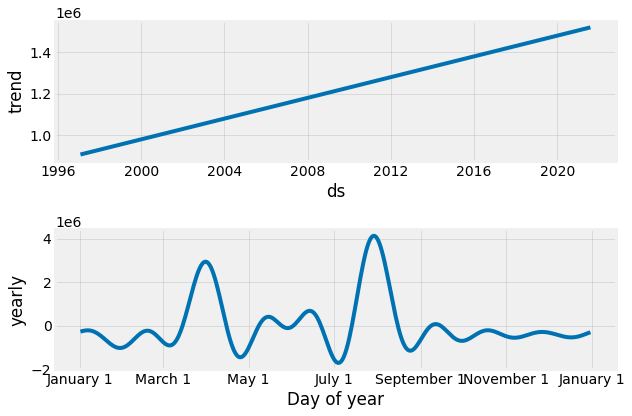

In [118]:
#visualize each component [Trends, yearly]

model.plot_components(prediction)

Checking the performance metrics and cross-validation

In [127]:
from prophet.diagnostics import cross_validation

In [129]:
#cross validation: 2020 - 2022
#train dataset: 2020 - 2021
#test dataset: 2021 - 2022
#validation: 2022 - 2023

In [130]:
df_cv = cross_validation(model, initial = '730 days', period = '180 days' ,horizon = '365 days')
df_cv.head()

INFO:prophet:Making 42 forecasts with cutoffs between 1999-05-19 00:00:00 and 2019-08-02 00:00:00


  0%|          | 0/42 [00:00<?, ?it/s]

INFO:prophet:n_changepoints greater than number of observations. Using 8.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpj3iva_s6/v7etephr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpj3iva_s6/9l8ni3py.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39273', 'data', 'file=/tmp/tmpj3iva_s6/v7etephr.json', 'init=/tmp/tmpj3iva_s6/9l8ni3py.json', 'output', 'file=/tmp/tmpj3iva_s6/prophet_modelgqro_inv/prophet_model-20230326051439.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
05:14:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:14:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 11.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpj3iva_s6/a5j3fydg.json
DEBUG:cmdstanpy:input tempfile

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,1999-06-01,9.302478e+05,9.219346e+05,9.383172e+05,987558.0,1999-05-19
1,1999-08-01,6.684311e+06,6.657422e+06,6.712552e+06,5840274.2,1999-05-19
2,1999-09-01,3.302023e+05,2.785912e+05,3.825343e+05,247140.0,1999-05-19
3,2000-02-01,5.988932e+04,-2.073894e+04,1.431863e+05,86345.0,1999-05-19
4,2000-04-01,2.744669e+06,2.627407e+06,2.863281e+06,3727101.2,1999-05-19


In [131]:
from prophet.diagnostics import performance_metrics

df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,42 days,3.473634e+11,589375.404643,485312.559350,0.339504,0.195193,0.267462,0.40
1,45 days,3.473600e+11,589372.551455,485263.850544,0.338882,0.195193,0.266863,0.40
2,47 days,4.021603e+11,634161.063214,530623.303157,0.346397,0.195193,0.275323,0.35
3,50 days,4.013227e+11,633500.329683,527150.920431,0.339283,0.189579,0.269383,0.35
4,52 days,4.586924e+11,677268.371216,562910.231250,0.343987,0.194078,0.274888,0.35


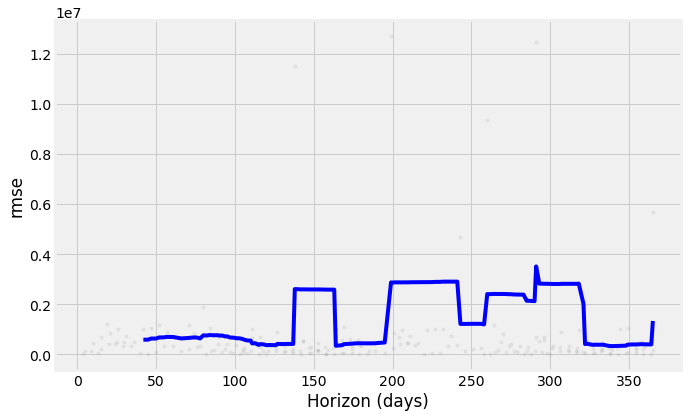

In [132]:
from prophet.plot import plot_cross_validation_metric

fig = plot_cross_validation_metric(df_cv, metric = 'rmse')